## MNISTで多項ロジスティック回帰を学習

### 1. データロード

In [58]:
# ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn import datasets 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [ ]:
# 1. データロード

dataset = datasets.load_digits()


# 画像データ
images = dataset['images']

# 正解レベル
target = dataset['target']

In [4]:
# データの確認
print('画像データのshape', images.shape)
print('正解ラベルのshape', target.shape)

画像データのshape (1797, 8, 8)
正解ラベルのshape (1797,)


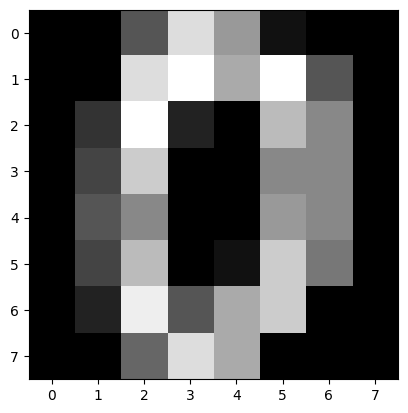

In [5]:
# imageを可視化して確かめる
import matplotlib.pyplot as plt

# 画像を表示するのは, plt.imshow()
# これが1797枚ある
plt.imshow(images[0], cmap='gray')

### 2. 前処理

In [6]:
# ラベルのエンコーディング(one-hotエンコーディング)
import torch.nn.functional as F

# この形ではダメ、なぜなら、numpyの形を取ってはいけない -> tensorの形に！
# あとは、引数にクラスの数を指定, num_classes
# F.one_hot(target)

y_true = F.one_hot(torch.tensor(target), num_classes=10)

# imagesもnumpy arrayなので、tensorにする。また、numpy arrayはfloat64型なので型変換する
# さらに、１次元配列として扱うので8x8 = 64の特徴量として扱うのでshapeを変える。
# 今のshapeはimage.shape -> (1797, 8, 8) -> (1797, 64)にする
images = torch.tensor(images, dtype=torch.float32).reshape(-1, 64)
images = (images - images.mean()) / images.std()

In [7]:
# 学習率の準備
learning_rate = 0.3

# 各イテレーションの損失を入れる
loss_log = []

### 3. パラメータの初期化

In [8]:
# wは10 x 64(出力 x 入力), b = 1 x 10 ( 1 x 出力)
W = torch.rand((10, 64), requires_grad=True)
b = torch.rand((1, 10), requires_grad=True)

### 4. softmaxの実装

In [9]:
# xは行列,
# torch.max(x)はデータごと, 行ごとのmaxを取る。データが3x10だとすると、最大値は3x1にしたい
# 左からrankを0とすると、rankを1とする、
def softmax(x):
    # 分子
    e_x = torch.exp(x - torch.max(x, dim=-1, keepdim=True)[0])
    # 分母
    return e_x / (torch.sum(e_x, dim=-1, keepdim=True) + 1e-10)



In [10]:
a = torch.rand((3, 5))
a

tensor([[0.9659, 0.2449, 0.7514, 0.2645, 0.7201],
        [0.0845, 0.1779, 0.7745, 0.5163, 0.4144],
        [0.0377, 0.4402, 0.2961, 0.8485, 0.6810]])

In [11]:
# 行ごとの最大値
torch.max(a, dim=-1)

torch.return_types.max(
values=tensor([0.9659, 0.7745, 0.8485]),
indices=tensor([0, 2, 3]))

In [12]:
# 形状を保つ
# これは2つ出力して、値と元のtensorのindexが何かを示している。-> 最大値だけを出力
torch.max(a, dim=-1, keepdim=True)[0]

tensor([[0.9659],
        [0.7745],
        [0.8485]])

In [13]:
# 行ごとにsumを取る
torch.sum(a, dim=-1, keepdim=True)

tensor([[2.9467],
        [1.9676],
        [2.3036]])

In [14]:
torch.exp(a - torch.max(a, dim=-1, keepdim=True)[0])

tensor([[1.0000, 0.4863, 0.8070, 0.4959, 0.7821],
        [0.5016, 0.5507, 1.0000, 0.7725, 0.6976],
        [0.4445, 0.6648, 0.5756, 1.0000, 0.8457]])

In [15]:
# cross entropyの実装
def cross_entropy(y_true, y_pred):
    # sumはスカラー(一つの値)で出力されるので、軸は関係ない
    
    return -torch.sum(y_true * torch.log(y_pred + 1e-10)) / y_true.shape[0]

### 5. for文で学習ループ作成

In [16]:
for epoch in range(5):
    running_loss = 0
    # それぞれのepochではデータを持ってきて、zを計算損失計算、softmax計算
    for i in range(len(target)):
        # 6. 入力データxおよび教師ラベルyを作成
        y_true_ = y_true[i].reshape(-1, 10)  # データ数 x　クラス数
        X = images[i].reshape(-1, 64)  # データ数 x 特徴量

        # 7. z計算
        Z = X@W.T + b

        # 8.softmaxで予測計算
        y_pred = softmax(Z)

        # 9. 損失計算
        loss = cross_entropy(y_true_, y_pred)
        # lossはtensorの形なので、.item()を使って数値にする
        loss_log.append(loss.item())
        # epochごとのlossを計算する
        running_loss += loss.item()

        # 10. 勾配を計算する
        loss.backward()

        # 11. パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 12. 勾配初期化
        W.grad.zero_()
        b.grad.zero_()

    # 13. 損失logを出力
    print(f'epoch : {epoch+1}: {running_loss/len(target)}')

epoch : 1: 0.8864995844397616
epoch : 2: 0.5119488638194429
epoch : 3: 0.37028031579867254
epoch : 4: 0.32157235617340824
epoch : 5: 0.24008751528628644


In [17]:
X = torch.tensor(images, dtype=torch.float32)

/tmp/ipykernel_32/1672824624.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(images, dtype=torch.float32)


In [18]:
z = X@W.T + b
y_pred = softmax(z)

In [19]:
torch.sum(torch.argmax(y_pred, dim=-1) == torch.argmax(y_true, dim=-1)) / y_true.shape[0]


tensor(0.9438)

In [20]:
# accuracy = 正しく分類できた/全サンプル数


In [21]:
# これだと、1次元の配列になってしまう
# .reshapeにすることで、行列の形にする。 データ数xクラス数
y_true[0].reshape(-1, 10)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [22]:
# これもデータ数x特徴量にしたいので行列の形にする -> reshape(-1, 64)
images[0].shape

torch.Size([64])

In [23]:
i = 0
y_true_ = y_true[i].reshape(-1, 10)  # データ数 x　クラス数
X = images[i].reshape(-1, 64)  # データ数 x 特徴量

# 7. z計算
z = X@W.T + b

In [24]:
z

tensor([[ 66.5817, -53.3446, -13.0230, -11.8788, -12.8798,  -8.3615,  -6.0680,
           5.4793,   2.5234,  19.3315]], grad_fn=<AddBackward0>)

In [25]:
X.shape

torch.Size([1, 64])

In [26]:
W.shape

torch.Size([10, 64])

In [27]:
b.shape

torch.Size([1, 10])

In [28]:
z.shape

torch.Size([1, 10])

In [29]:
y_pred = softmax(z)
loss = cross_entropy(y_true, y_pred)

In [30]:
loss.backward()

## ミニバッチ学習

In [45]:
# ミニバッチを作成する
# ミニバッチを作成するが、データをシャッフルする必要あり。
# でもそれぞれimageとtargetは同じようにシャッフルする必要あり(対応しているから)
# だから、indexをシャッフルする

np.random.permutation(len(target))



array([ 775,  560,  562, ..., 1256,  582,  508])

In [51]:
#　バッチサイズ
batch_size = 30

# データ数をバッチサイズで割ったら59.9になった。
# つまり、60個のバッチがあればいいから、繰り上げる
num_batches = np.ceil(len(target) / batch_size).astype(int)


In [53]:
# パラメータの初期化
W = torch.rand((10, 64), requires_grad=True)
b = torch.rand((1, 10), requires_grad=True)

# 学習率の準備
learning_rate = 0.3
# 各イテレーションの損失を入れる
loss_log = []

for epoch in range(5):
    shuffle_indices = np.random.permutation(len(target))
    running_loss = 0
    # それぞれのepochではデータを持ってきて、zを計算損失計算、softmax計算
    for i in range(num_batches):

        # ミニバッチ作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffle_indices[start:end]
        
        # 6. 入力データxおよび教師ラベルyを作成
        y_true_ = y_true[batch_indices, :]  # データ数 x　クラス数
        X = images[batch_indices, :] # データ数 x 特徴量
        # import pdb; pdb.set_trace()
        
        # 7. z計算
        Z = X@W.T + b

        # 8.softmaxで予測計算
        y_pred = softmax(Z)

        # 9. 損失計算
        loss = cross_entropy(y_true_, y_pred)
        # lossはtensorの形なので、.item()を使って数値にする
        loss_log.append(loss.item())
        # epochごとのlossを計算する
        running_loss += loss.item()

        # 10. 勾配を計算する
        loss.backward()

        # 11. パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 12. 勾配初期化
        W.grad.zero_()
        b.grad.zero_()

    # 13. 損失logを出力
    print(f'epoch : {epoch+1}: {running_loss/num_batches}')

epoch : 1: 0.759277435640494
epoch : 2: 0.22962282684942087
epoch : 3: 0.1709172897040844
epoch : 4: 0.14570833537727595
epoch : 5: 0.13089023878177006


In [56]:
X = torch.tensor(images, dtype=torch.float32)
z = X@W.T + b
y_pred = softmax(z)

/tmp/ipykernel_32/1767331965.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(images, dtype=torch.float32)


In [57]:

torch.sum(torch.argmax(y_pred, dim=-1) == torch.argmax(y_true, dim=-1)) / y_true.shape[0]

tensor(0.9766)

## 学習データと検証データに分ける

In [64]:
# 1. データロード

dataset = datasets.load_digits()
# 画像データ
images = dataset['images']
# 正解レベル
target = dataset['target']







In [71]:
# 学習データと検証データを分割する
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)
X_mean = X_train.mean()
X_std = X_train.std()

X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std


In [72]:
X_val.shape

(360, 8, 8)

In [73]:
# ラベルのエンコーディング(one-hotエンコーディング)
import torch.nn.functional as F

# この形ではダメ、なぜなら、numpyの形を取ってはいけない -> tensorの形に！
# あとは、引数にクラスの数を指定, num_classes
# F.one_hot(target)

y_train = F.one_hot(torch.tensor(y_train), num_classes=10)

# imagesもnumpy arrayなので、tensorにする。また、numpy arrayはfloat64型なので型変換する
# さらに、１次元配列として扱うので8x8 = 64の特徴量として扱うのでshapeを変える。
# 今のshapeはimage.shape -> (1797, 8, 8) -> (1797, 64)にする
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 64)
y_val = F.one_hot(torch.tensor(y_val), num_classes=10)
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 64)

X_mean = X_train.mean()
X_std = X_train.std()

X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std

In [84]:
# バッチサイズ
batch_size = 30
num_batches = np.ceil((len(y_train)) / batch_size).astype(int)

# パラメータの初期化
W = torch.rand((10, 64), requires_grad=True)
b = torch.rand((1, 10), requires_grad=True)
# ログ
train_losses = []
val_losses = []
val_accuracies = []

# 学習率の準備
learning_rate = 0.3
# 各イテレーションの損失を入れる
loss_log = []

epoches = 30
for epoch in range(epoches):
    shuffle_indices = np.random.permutation(len(y_train))
    running_loss = 0
    # それぞれのepochではデータを持ってきて、zを計算損失計算、softmax計算
    for i in range(num_batches):

        # ミニバッチ作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffle_indices[start:end]
        
        # 6. 入力データxおよび教師ラベルyを作成
        y_true_ = y_train[batch_indices, :]  # データ数 x　クラス数
        X = X_train[batch_indices, :] # データ数 x 特徴量
        # import pdb; pdb.set_trace()
        
        # 7. z計算
        Z = X@W.T + b

        # 8.softmaxで予測計算
        y_pred = softmax(Z)

        # 9. 損失計算
        loss = cross_entropy(y_true_, y_pred)
        # lossはtensorの形なので、.item()を使って数値にする
        loss_log.append(loss.item())
        # epochごとのlossを計算する
        running_loss += loss.item()

        # 10. 勾配を計算する
        loss.backward()

        # 11. パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 12. 勾配初期化
        W.grad.zero_()
        b.grad.zero_()

    # validation
    with torch.no_grad():
        Z_val = X_val@W.T + b
        y_pred_val = softmax(Z_val)

        val_loss = cross_entropy(y_val, y_pred_val)

        # accuracy
        val_accuracy = torch.sum(torch.argmax(y_pred_val, dim=-1) == torch.argmax(y_val, dim=-1)) / y_true.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    # 13. 損失logを出力
    print(f'epoch : {epoch+1}: train loss : {running_loss/num_batches}, val loss : {val_loss.item()}, val accuracy {val_accuracy.item()}')



epoch : 1: train loss : 0.895814752827088, val loss : 0.33431240916252136, val accuracy 0.1830829232931137
epoch : 2: train loss : 0.2789216300783058, val loss : 0.22190693020820618, val accuracy 0.1869782954454422
epoch : 3: train loss : 0.2024990526648859, val loss : 0.19011132419109344, val accuracy 0.18809126317501068
epoch : 4: train loss : 0.17368271380352476, val loss : 0.15954992175102234, val accuracy 0.1897607147693634
epoch : 5: train loss : 0.15232484259953102, val loss : 0.15181823074817657, val accuracy 0.19143016636371613
epoch : 6: train loss : 0.1375718715135008, val loss : 0.13795597851276398, val accuracy 0.19198665022850037
epoch : 7: train loss : 0.1277735698580121, val loss : 0.12974214553833008, val accuracy 0.1936560869216919
epoch : 8: train loss : 0.11927324971960236, val loss : 0.12567250430583954, val accuracy 0.19309960305690765
epoch : 9: train loss : 0.10913123159358899, val loss : 0.12671983242034912, val accuracy 0.1936560869216919
epoch : 10: train los

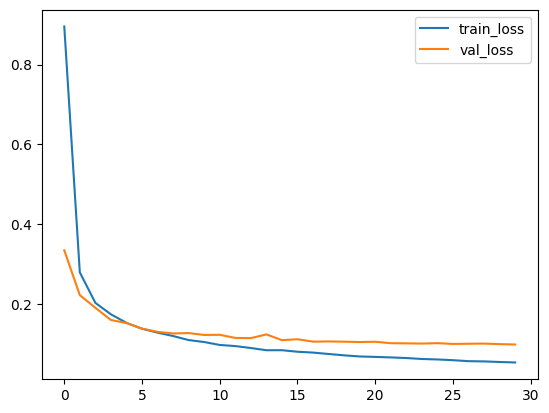

In [86]:
plt.plot(train_losses, label = 'train_loss')
plt.plot(val_losses, label = 'val_loss')
plt.legend()